In [1]:
pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [3]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 65.7MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 23.1MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 127MB/s]


In [4]:
# Import Libraries 
import numpy as np 
import pandas as pd 

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Modelling 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [5]:
# Get the training and test set
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

Knowing the Data

In [ ]:
train_df['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [ ]:
train_df[train_df['target']==0]['text'].values[0]

"What's up man?"

In [ ]:
train_df[train_df['target']==1]['text'].values[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

Data Visualization 

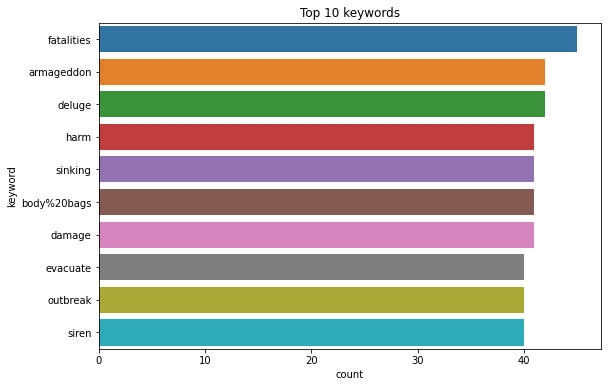

In [ ]:
# Most Common Words
plt.figure(figsize=(9,6))
sns.countplot(y=train_df.keyword, order = train_df.keyword.value_counts().iloc[:10].index)
plt.title('Top 10 keywords')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


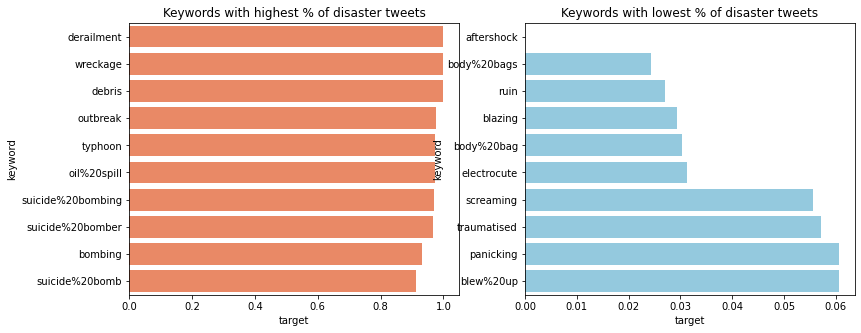

In [ ]:
# Keywords with highest proportion 
top_disaster = train_df.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_non_disaster = train_df.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(top_disaster, top_disaster.index, color='coral')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_non_disaster, top_non_disaster.index, color='skyblue')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

In [ ]:
# Simple Model
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

# Set up count vectorizer for training and test set
train_vectors = count_vectorizer.fit_transform(train_df["text"])
test_vectors = count_vectorizer.transform(test_df["text"])

# Make model
clf = linear_model.RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
clf.fit(train_vectors, train_df["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [ ]:
# First Submission 
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["target"] = clf.predict(test_vectors)
sample_submission.to_csv("submission.csv", index=False)
# this submission gives accuracy of 0.78 

Data Preprocessing 

In [ ]:
import re

test_str = train_df.loc[417, 'text']

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both train and test datasets
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x: clean_text(x))

In [ ]:
# display the updated text 
train_df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [ ]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train_df = process_text(train_df)
test_df = process_text(test_df)


TD IDF Count - a statistical measure that evaluates how relevant a word is to a document of words, which in our case, a dictionary of disaster and non-disaster tweets. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_tfid = tfid.fit_transform(train_df['text']).toarray()
y = train_df['target']

In [ ]:
# Spiliting the DataSet
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfid, y, test_size = 0.2, random_state = 0)

Logistics Regression Approach

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr=LogisticRegression()
lr.fit(X_train, y_train)

y_pred=lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.8095863427445831

In [ ]:
# Trying KFold since it will be able to increase accuracy with validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

lr = LogisticRegression()

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_val_score(lr, X_tfid, y, cv=kfold, scoring='accuracy',)   # in case cv value is interger, it will automaticallu take KFold or StratifiedKFold 
cv_results.mean()

0.80257152052238

In [ ]:
import warnings
warnings.filterwarnings('ignore') # ignore the warning 

In [ ]:
# Use RandomizedSearchCV to find the best param 
from sklearn.model_selection import RandomizedSearchCV
params= {'C': [0.001, 0.01, 0.1, 1, 10, 100, ] , 'penalty':['l1','l2']}
RS_lr = RandomizedSearchCV(lr,params,return_train_score=True,error_score=0,random_state=42,cv=kfold)
RS_lr.fit(X_train, y_train)

print(RS_lr.best_estimator_)
print(RS_lr.best_params_)
print(RS_lr.best_score_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
{'penalty': 'l2', 'C': 1}
0.8


In [ ]:
# GridSearchCV allows us to tune the param automatically and easier to find the best param 
from sklearn.model_selection import GridSearchCV
GS_lr=GridSearchCV(lr, params,cv=kfold)
GS_lr.fit(X_train, y_train)

print(GS_lr.best_estimator_)
print(GS_lr.best_params_)
print(GS_lr.best_score_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
{'C': 1, 'penalty': 'l2'}
0.8


In [ ]:
prediction = GS_lr.predict(X_test)
accuracy_score(y_test,prediction)

0.8095863427445831

In [ ]:
X_test_tfid = tfid.transform(test_df['text'])

In [ ]:
y_pred = GS_lr.predict(X_test_tfid)

In [ ]:
submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['target'] = y_pred
submission.to_csv('submission.csv', index=False)
# Logistics Regresison gives the accuracy of almost 0.80 